In [5]:
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split

# Path to your spectrograms folder
spectrogram_root = "E:/birdclef-2024/spectrograms"
samples_per_class = 50  # Max number of samples per species

data = []
species_dirs = os.listdir(spectrogram_root)

for species in species_dirs:
    species_dir = os.path.join(spectrogram_root, species)
    if not os.path.isdir(species_dir):
        continue
    
    all_files = [f for f in os.listdir(species_dir) if f.endswith(".png")]
    
    # Take all if less than 50, else randomly sample 50
    selected_files = all_files if len(all_files) <= samples_per_class else random.sample(all_files, samples_per_class)

    for f in selected_files:
        data.append({
            "filepath": os.path.join(species_dir, f),
            "label": species
        })

# Create DataFrame and save full balanced dataset
df = pd.DataFrame(data)
df.to_csv("balanced_dataset.csv", index=False)

# Stratified Train/Validation Split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)

print(f"Species included: {df['label'].nunique()}")
print(f"Total: {len(df)}, Train: {len(train_df)}, Val: {len(val_df)}")


Species included: 181
Total: 8901, Train: 7120, Val: 1781


In [63]:
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import os

# Read CSVs
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")

label2idx = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}

# Image Transform
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [65]:
class BirdCLEFDataset(Dataset):
    def __init__(self, df, transform=None, label2idx=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label2idx = label2idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image = Image.open(row['filepath']).convert("RGB")
        label = self.label2idx[row['label']]
        
        if self.transform:
            image = self.transform(image)
        return image, label


In [67]:
train_dataset = BirdCLEFDataset(train_df, transform=image_transforms, label2idx=label2idx)
val_dataset = BirdCLEFDataset(val_df, transform=image_transforms, label2idx=label2idx)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [13]:
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 181)  # 181 classes
model = model.to(device)


C:\Users\ONGC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ONGC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [17]:
for epoch in range(10):  # You can increase this
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}")


Epoch 1, Training Loss: 1132.0539
Epoch 2, Training Loss: 969.6670
Epoch 3, Training Loss: 791.1960
Epoch 4, Training Loss: 647.7776
Epoch 5, Training Loss: 529.2510
Epoch 6, Training Loss: 434.5001
Epoch 7, Training Loss: 352.4254
Epoch 8, Training Loss: 284.3204
Epoch 9, Training Loss: 222.6706
Epoch 10, Training Loss: 175.1101


In [19]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

evaluate(model, val_loader)


Validation Accuracy: 52.84%


In [21]:
torch.save(model.state_dict(), "birdclef_efficientnet_b0.pth")


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, top_k_accuracy_score
import numpy as np

def get_validation_metrics(model, loader, label_names):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    print("🔍 Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=label_names, zero_division=0))

    print("🔍 Confusion Matrix:\n")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    # Optional: Top-3 Accuracy
    top3 = top_k_accuracy_score(all_labels, np.array(all_probs), k=3)
    print(f"\n🎯 Top-3 Accuracy: {top3 * 100:.2f}%")

    return all_preds, all_labels


In [27]:
label_names = list(train_dataset.label2idx.keys())


In [29]:
get_validation_metrics(model, val_loader, label_names)


🔍 Classification Report:

              precision    recall  f1-score   support

      asbfly       0.44      0.40      0.42        10
     ashdro1       0.17      0.10      0.12        10
     ashpri1       0.50      0.30      0.38        10
     ashwoo2       0.56      0.50      0.53        10
     asikoe2       0.83      0.50      0.62        10
     asiope1       0.50      0.50      0.50         4
     aspswi1       0.44      0.80      0.57        10
     barfly1       0.80      0.80      0.80        10
      barswa       0.50      0.30      0.38        10
      bcnher       0.44      0.40      0.42        10
     bkcbul1       0.62      0.80      0.70        10
     bkrfla1       0.62      0.50      0.56        10
     bkskit1       0.78      0.70      0.74        10
      bkwsti       0.53      0.80      0.64        10
     bladro1       0.44      0.40      0.42        10
     blaeag1       1.00      1.00      1.00         8
     blakit1       0.30      0.30      0.30        10
 

([89,
  51,
  23,
  116,
  60,
  6,
  47,
  126,
  111,
  59,
  98,
  144,
  1,
  94,
  172,
  48,
  115,
  111,
  104,
  111,
  10,
  100,
  100,
  72,
  28,
  176,
  100,
  84,
  165,
  160,
  9,
  125,
  104,
  129,
  59,
  136,
  34,
  36,
  77,
  107,
  166,
  74,
  140,
  24,
  74,
  68,
  51,
  57,
  130,
  33,
  133,
  95,
  38,
  74,
  115,
  114,
  6,
  10,
  14,
  54,
  111,
  123,
  93,
  39,
  119,
  122,
  174,
  169,
  180,
  97,
  127,
  80,
  83,
  152,
  47,
  34,
  116,
  41,
  13,
  0,
  159,
  116,
  177,
  31,
  66,
  70,
  87,
  6,
  112,
  92,
  122,
  98,
  91,
  115,
  33,
  142,
  92,
  74,
  27,
  22,
  123,
  67,
  136,
  95,
  166,
  98,
  103,
  1,
  101,
  5,
  26,
  14,
  112,
  160,
  83,
  82,
  149,
  6,
  103,
  22,
  29,
  20,
  28,
  74,
  44,
  18,
  152,
  166,
  102,
  23,
  152,
  0,
  93,
  12,
  111,
  103,
  45,
  10,
  57,
  162,
  45,
  153,
  136,
  158,
  85,
  18,
  36,
  83,
  157,
  67,
  172,
  172,
  59,
  75,
  79,
  62,
  63,
  1

In [31]:
def collect_predictions(model, loader, label_names, dataframe):
    model.eval()
    results = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for j in range(len(labels)):
                results.append({
                    "filepath": dataframe.iloc[i * loader.batch_size + j]["filepath"],
                    "true_label": label_names[labels[j].item()],
                    "pred_label": label_names[preds[j].item()],
                    "correct": labels[j].item() == preds[j].item()
                })

    return pd.DataFrame(results)


In [33]:
prediction_df = collect_predictions(model, val_loader, label_names, val_df)
prediction_df.to_csv("val_predictions.csv", index=False)

# Preview
print(prediction_df.head())


                                            filepath true_label pred_label  \
0  E:/birdclef-2024/spectrograms\whcbar1\XC635414...    whcbar1    insbab1   
1  E:/birdclef-2024/spectrograms\darter2\XC756478...    darter2    darter2   
2  E:/birdclef-2024/spectrograms\brcful1\XC816788...    brcful1    brcful1   
3  E:/birdclef-2024/spectrograms\malpar1\XC197770...    malpar1    moipig1   
4  E:/birdclef-2024/spectrograms\goflea1\XC684239...    goflea1    goflea1   

   correct  
0    False  
1     True  
2     True  
3    False  
4     True  


In [35]:
correct_preds = prediction_df[prediction_df["correct"] == True]
incorrect_preds = prediction_df[prediction_df["correct"] == False]

print(f"✅ Correct Predictions: {len(correct_preds)}")
print(f"❌ Incorrect Predictions: {len(incorrect_preds)}")
print(f"🔢 Total Samples Evaluated: {len(prediction_df)}")


✅ Correct Predictions: 941
❌ Incorrect Predictions: 840
🔢 Total Samples Evaluated: 1781


C:\Users\ONGC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


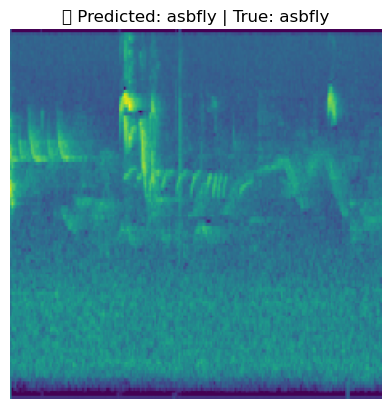

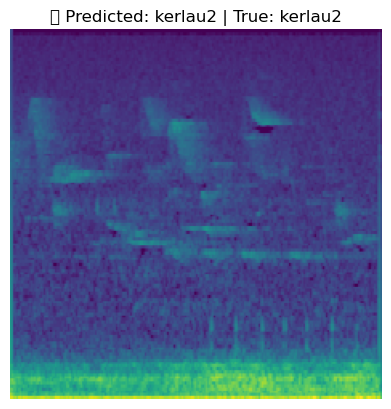

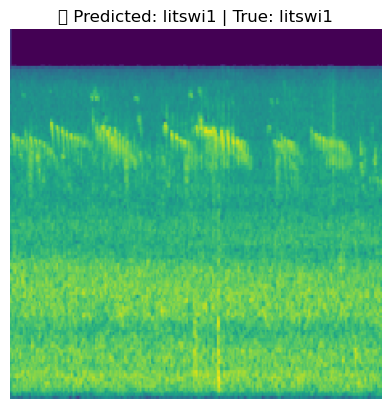

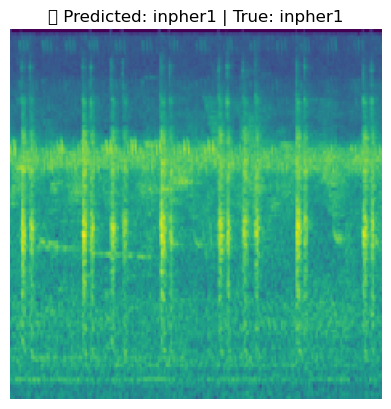

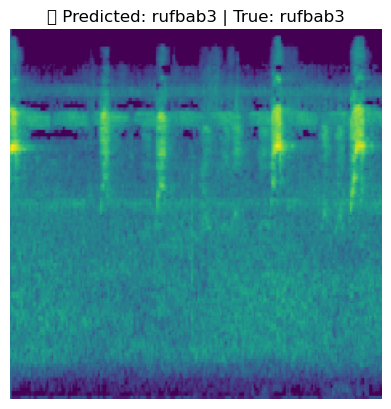

C:\Users\ONGC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


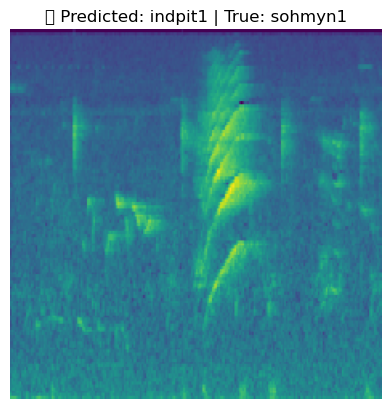

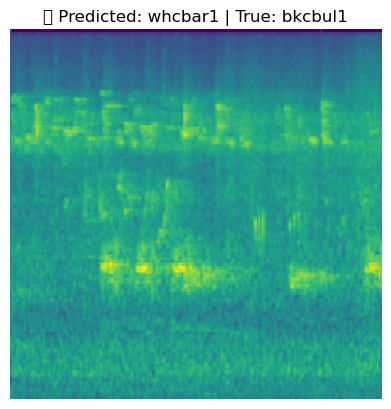

In [39]:
from PIL import Image
import matplotlib.pyplot as plt

# Show 5 correct predictions
for _, row in correct_preds.sample(5).iterrows():
    img = Image.open(row['filepath'])
    plt.imshow(img)
    plt.title(f"✅ Predicted: {row['pred_label']} | True: {row['true_label']}")
    plt.axis("off")
    plt.show()

# Show 2 incorrect predictions
for _, row in incorrect_preds.sample(2).iterrows():
    img = Image.open(row['filepath'])
    plt.imshow(img)
    plt.title(f"❌ Predicted: {row['pred_label']} | True: {row['true_label']}")
    plt.axis("off")
    plt.show()


In [43]:
import os
import pandas as pd

spectrogram_root = "E:/birdclef-2024/spectrograms"

# Count total species and samples
species_dirs = [d for d in os.listdir(spectrogram_root) if os.path.isdir(os.path.join(spectrogram_root, d))]
total_species = len(species_dirs)

total_samples = 0
for species in species_dirs:
    species_dir = os.path.join(spectrogram_root, species)
    files = [f for f in os.listdir(species_dir) if f.endswith('.png')]
    total_samples += len(files)

# Read train/val splits
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")

# Print stats
print(f"Species included: {total_species}")
print(f"Total: {total_samples}, Train: {len(train_df)}, Val: {len(val_df)}")


Species included: 181
Total: 329573, Train: 7120, Val: 1781


In [77]:
 from torchvision import transforms

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [79]:
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Replace final FC layer
model.fc = nn.Linear(model.fc.in_features, 181)
model = model.to(device)


C:\Users\ONGC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ONGC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# LR scheduler: reduce LR if val loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)


C:\Users\ONGC\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [83]:
from tqdm import tqdm

best_val_acc = 0

for epoch in range(15):  # Or increase based on performance
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    # Wrap the training loader with tqdm for progress bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{15}", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar description
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    val_acc = evaluate(model, val_loader)

    scheduler.step(avg_loss)

    print(f"📘 Epoch {epoch+1} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")
        print(f"✅ Model saved at Epoch {epoch+1} with Val Acc: {val_acc:.2f}%")


📘 Epoch 1 | Avg Loss: 4.6236 | Train Acc: 10.67% | Val Acc: 22.63%
✅ Model saved at Epoch 1 with Val Acc: 22.63%


📘 Epoch 2 | Avg Loss: 3.1347 | Train Acc: 36.49% | Val Acc: 40.71%
✅ Model saved at Epoch 2 with Val Acc: 40.71%


📘 Epoch 3 | Avg Loss: 2.0186 | Train Acc: 59.16% | Val Acc: 47.95%
✅ Model saved at Epoch 3 with Val Acc: 47.95%


📘 Epoch 4 | Avg Loss: 1.1670 | Train Acc: 77.81% | Val Acc: 53.68%
✅ Model saved at Epoch 4 with Val Acc: 53.68%


📘 Epoch 5 | Avg Loss: 0.5567 | Train Acc: 91.43% | Val Acc: 57.10%
✅ Model saved at Epoch 5 with Val Acc: 57.10%


📘 Epoch 6 | Avg Loss: 0.2201 | Train Acc: 97.67% | Val Acc: 59.29%
✅ Model saved at Epoch 6 with Val Acc: 59.29%


📘 Epoch 7 | Avg Loss: 0.0752 | Train Acc: 99.68% | Val Acc: 61.71%
✅ Model saved at Epoch 7 with Val Acc: 61.71%


📘 Epoch 8 | Avg Loss: 0.0313 | Train Acc: 99.93% | Val Acc: 63.28%
✅ Model saved at Epoch 8 with Val Acc: 63.28%


📘 Epoch 9 | Avg Loss: 0.0172 | Train Acc: 99.96% | Val Acc: 62.72%


📘 Epoch 10 | Avg Loss: 0.0121 | Train Acc: 99.96% | Val Acc: 63.73%
✅ Model saved at Epoch 10 with Val Acc: 63.73%


📘 Epoch 11 | Avg Loss: 0.0079 | Train Acc: 99.97% | Val Acc: 62.89%


📘 Epoch 12 | Avg Loss: 0.0075 | Train Acc: 99.99% | Val Acc: 63.78%
✅ Model saved at Epoch 12 with Val Acc: 63.78%


📘 Epoch 13 | Avg Loss: 0.0056 | Train Acc: 99.99% | Val Acc: 64.18%
✅ Model saved at Epoch 13 with Val Acc: 64.18%


📘 Epoch 14 | Avg Loss: 0.0046 | Train Acc: 99.97% | Val Acc: 64.23%
✅ Model saved at Epoch 14 with Val Acc: 64.23%


📘 Epoch 15 | Avg Loss: 0.0039 | Train Acc: 99.99% | Val Acc: 64.40%
✅ Model saved at Epoch 15 with Val Acc: 64.40%


In [85]:
import torch

model.load_state_dict(torch.load("best_resnet50_model.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [87]:
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
import numpy as np

def get_predictions(model, loader, label_names):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

label_names = list(train_dataset.label2idx.keys())
y_true, y_pred, y_probs = get_predictions(model, val_loader, label_names)

# Classification report
from sklearn.metrics import classification_report
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

# Top-3 accuracy
top3 = top_k_accuracy_score(y_true, y_probs, k=3)
print(f"\n🎯 Top-3 Accuracy: {top3 * 100:.2f}%")


🔍 Classification Report:
              precision    recall  f1-score   support

      asbfly       0.17      0.20      0.18        10
     ashdro1       0.67      0.40      0.50        10
     ashpri1       0.88      0.70      0.78        10
     ashwoo2       0.60      0.60      0.60        10
     asikoe2       0.86      0.60      0.71        10
     asiope1       0.50      0.50      0.50         4
     aspswi1       0.75      0.90      0.82        10
     barfly1       0.89      0.80      0.84        10
      barswa       0.50      0.60      0.55        10
      bcnher       0.62      0.50      0.56        10
     bkcbul1       0.80      0.80      0.80        10
     bkrfla1       0.75      0.30      0.43        10
     bkskit1       0.73      0.80      0.76        10
      bkwsti       0.70      0.70      0.70        10
     bladro1       0.57      0.40      0.47        10
     blaeag1       1.00      1.00      1.00         8
     blakit1       0.44      0.40      0.42        10
  

In [91]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Pick a layer (for ResNet-50, usually 'layer4')
cam_extractor = GradCAM(model, target_layer="layer4")

def visualize_gradcam(image_tensor, label_idx):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Forward pass
    output = model(image_tensor)
    pred = output.argmax(dim=1).item()

    # Extract CAM
    activation_map = cam_extractor(pred, output)[0].cpu()
    
    # Convert image tensor to PIL for display
    image_np = image_tensor.squeeze().cpu()
    image_np = (image_np * 0.5) + 0.5  # de-normalize
    image_np = to_pil_image(image_np)

    # Plot image and CAM overlay
    plt.imshow(image_np)
    plt.imshow(activation_map.squeeze(), cmap='jet', alpha=0.4)
    plt.title(f"True: {label_names[label_idx]} | Pred: {label_names[pred]}")
    plt.axis('off')
    plt.show()


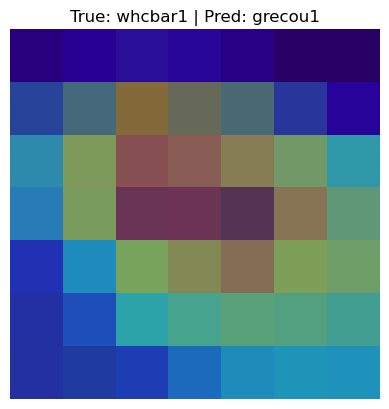

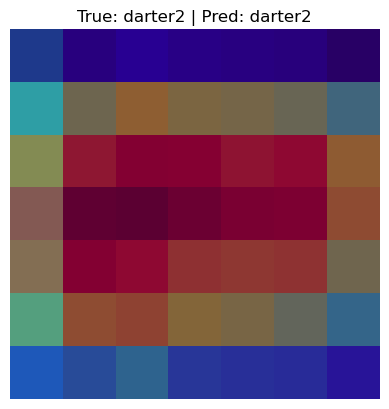

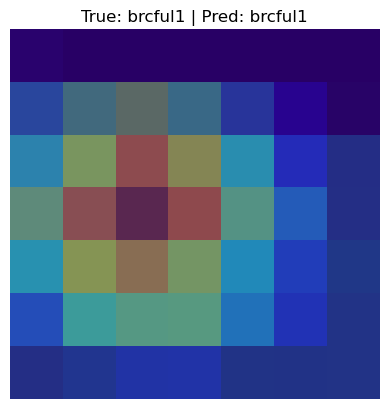

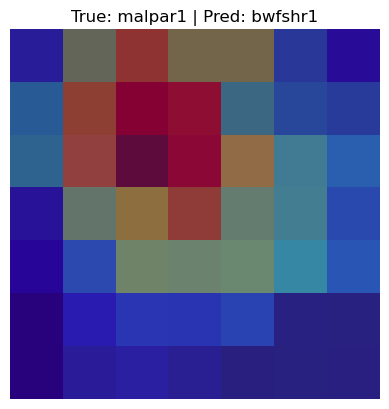

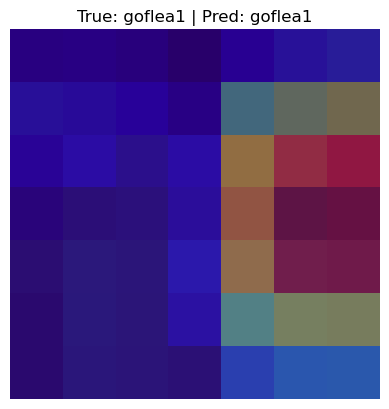

In [93]:
# Visualize a few from validation set
for i in range(5):
    img, label = val_dataset[i]
    visualize_gradcam(img, label)


In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# ✅ Custom CNN from Scratch with CUDA, BatchNorm, and Dropout
class CustomBirdCNN(nn.Module):
    def __init__(self, num_classes=181):
        super(CustomBirdCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Transforms
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ✅ Model, Loss, Optimizer
model = CustomBirdCNN(num_classes=181).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# ✅ Training Loop Template (requires train_loader, val_loader, evaluate function)
best_val_acc = 0
num_epochs = 15

for epoch in range(10):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{10}", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    val_acc = evaluate(model, val_loader)

    scheduler.step(avg_loss)
    print(f"\nEpoch {epoch+1} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_custom_cnn_model.pth")
        print(f"✅ Model saved at Epoch {epoch+1} with Val Acc: {val_acc:.2f}%")


Using device: cpu


C:\Users\ONGC\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1 | Avg Loss: 5.2924 | Train Acc: 0.87% | Val Acc: 1.24%
✅ Model saved at Epoch 1 with Val Acc: 1.24%



Epoch 2 | Avg Loss: 5.1893 | Train Acc: 0.87% | Val Acc: 1.18%



Epoch 3 | Avg Loss: 5.1807 | Train Acc: 1.07% | Val Acc: 1.12%



Epoch 4 | Avg Loss: 5.1719 | Train Acc: 0.96% | Val Acc: 1.24%



Epoch 5 | Avg Loss: 5.1695 | Train Acc: 0.69% | Val Acc: 1.29%
✅ Model saved at Epoch 5 with Val Acc: 1.29%



Epoch 6 | Avg Loss: 5.1577 | Train Acc: 1.15% | Val Acc: 1.74%
✅ Model saved at Epoch 6 with Val Acc: 1.74%



Epoch 7 | Avg Loss: 5.1466 | Train Acc: 1.04% | Val Acc: 1.74%



Epoch 8 | Avg Loss: 5.1127 | Train Acc: 1.35% | Val Acc: 2.41%
✅ Model saved at Epoch 8 with Val Acc: 2.41%



Epoch 9 | Avg Loss: 5.0853 | Train Acc: 1.45% | Val Acc: 2.98%
✅ Model saved at Epoch 9 with Val Acc: 2.98%



Epoch 10 | Avg Loss: 5.0526 | Train Acc: 1.62% | Val Acc: 2.98%


In [99]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd
from PIL import Image

# ✅ Residual Block Definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

# ✅ ResNet-like CNN
class ResNetLikeCNN(nn.Module):
    def __init__(self, num_classes=181):
        super(ResNetLikeCNN, self).__init__()

        self.entry = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, downsample=True)
        self.layer3 = self._make_layer(128, 256, 2, downsample=True)
        self.layer4 = self._make_layer(256, 512, 2, downsample=True)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, downsample=False):
        layers = [ResidualBlock(in_channels, out_channels, downsample)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.entry(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Transforms
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ✅ Dataset Class
class BirdCLEFDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label2idx = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["filepath"]).convert("RGB")
        label = self.label2idx[row["label"]]
        if self.transform:
            image = self.transform(image)
        return image, label

# ✅ Load train/val CSVs
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")

# ✅ Create Datasets and Loaders
train_dataset = BirdCLEFDataset(train_df, transform=image_transforms)
val_dataset = BirdCLEFDataset(val_df, transform=image_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# ✅ Evaluation Function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

# ✅ Model, Loss, Optimizer
model = ResNetLikeCNN(num_classes=181).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# ✅ Training Loop with TQDM & Model Saving
best_val_acc = 0
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    val_acc = evaluate(model, val_loader)

    scheduler.step(avg_loss)
    print(f"\nEpoch {epoch+1} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnetlike_cnn.pth")
        print(f"✅ Model saved at Epoch {epoch+1} with Val Acc: {val_acc:.2f}%")


C:\Users\ONGC\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cpu



Epoch 1 | Avg Loss: 5.1418 | Train Acc: 1.87% | Val Acc: 2.64%
✅ Model saved at Epoch 1 with Val Acc: 2.64%



Epoch 2 | Avg Loss: 4.7224 | Train Acc: 5.86% | Val Acc: 7.80%
✅ Model saved at Epoch 2 with Val Acc: 7.80%



Epoch 3 | Avg Loss: 4.2080 | Train Acc: 12.56% | Val Acc: 14.82%
✅ Model saved at Epoch 3 with Val Acc: 14.82%



Epoch 4 | Avg Loss: 3.8049 | Train Acc: 19.10% | Val Acc: 16.34%
✅ Model saved at Epoch 4 with Val Acc: 16.34%



Epoch 5 | Avg Loss: 3.4663 | Train Acc: 25.38% | Val Acc: 24.82%
✅ Model saved at Epoch 5 with Val Acc: 24.82%



Epoch 6 | Avg Loss: 3.1814 | Train Acc: 30.38% | Val Acc: 28.80%
✅ Model saved at Epoch 6 with Val Acc: 28.80%



Epoch 7 | Avg Loss: 2.9317 | Train Acc: 35.48% | Val Acc: 29.37%
✅ Model saved at Epoch 7 with Val Acc: 29.37%



Epoch 8 | Avg Loss: 2.7035 | Train Acc: 40.76% | Val Acc: 31.61%
✅ Model saved at Epoch 8 with Val Acc: 31.61%



Epoch 9 | Avg Loss: 2.4697 | Train Acc: 45.08% | Val Acc: 35.43%
✅ Model saved at Epoch 9 with Val Acc: 35.43%



Epoch 10 | Avg Loss: 2.2759 | Train Acc: 49.34% | Val Acc: 35.65%
✅ Model saved at Epoch 10 with Val Acc: 35.65%



Epoch 11 | Avg Loss: 2.0935 | Train Acc: 53.40% | Val Acc: 41.66%
✅ Model saved at Epoch 11 with Val Acc: 41.66%



Epoch 12 | Avg Loss: 1.9121 | Train Acc: 58.09% | Val Acc: 40.37%



Epoch 13 | Avg Loss: 1.7572 | Train Acc: 60.32% | Val Acc: 42.06%
✅ Model saved at Epoch 13 with Val Acc: 42.06%



Epoch 14 | Avg Loss: 1.5845 | Train Acc: 65.39% | Val Acc: 44.92%
✅ Model saved at Epoch 14 with Val Acc: 44.92%



Epoch 15 | Avg Loss: 1.4177 | Train Acc: 69.19% | Val Acc: 46.15%
✅ Model saved at Epoch 15 with Val Acc: 46.15%


In [101]:
model = ResNetLikeCNN(num_classes=181).to(device)
model.load_state_dict(torch.load("best_resnetlike_cnn.pth"))
model.eval()


ResNetLikeCNN(
  (entry): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

In [103]:
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
import numpy as np

def get_predictions(model, loader, label_names):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [105]:
label_names = list(train_dataset.label2idx.keys())
y_true, y_pred, y_probs = get_predictions(model, val_loader, label_names)

print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

top3 = top_k_accuracy_score(y_true, y_probs, k=3)
print(f"\n🎯 Top-3 Accuracy: {top3 * 100:.2f}%")


🔍 Classification Report:
              precision    recall  f1-score   support

      asbfly       0.08      0.10      0.09        10
     ashdro1       0.17      0.10      0.12        10
     ashpri1       0.67      0.40      0.50        10
     ashwoo2       0.80      0.40      0.53        10
     asikoe2       0.43      0.30      0.35        10
     asiope1       0.50      0.25      0.33         4
     aspswi1       0.35      0.60      0.44        10
     barfly1       1.00      1.00      1.00        10
      barswa       0.25      0.30      0.27        10
      bcnher       0.50      0.40      0.44        10
     bkcbul1       0.89      0.80      0.84        10
     bkrfla1       0.30      0.70      0.42        10
     bkskit1       0.75      0.60      0.67        10
      bkwsti       0.56      0.50      0.53        10
     bladro1       0.50      0.10      0.17        10
     blaeag1       0.80      1.00      0.89         8
     blakit1       0.38      0.30      0.33        10
  